<a href="https://colab.research.google.com/github/skku-kdj/MLRobustness_eval/blob/main/art/attack/evasion/whitebox/Auto_PGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Auto PGD

Auto PGD is the advance version of PGD, proposed in 2020. This is link of the paper(https://arxiv.org/abs/2003.01690).

In this study, Auto-PGD aim to improve PGD's problem. First, fixed step size, second, agnostic of the budget in general, last, unware of the trend. So, Auto-PGD is implemented as step-size free PGD.

In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
import numpy as np
import os

import torch
from torch import nn, optim

import torchvision
from torchvision.models import resnet50
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import AutoProjectedGradientDescent

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab_Notebooks/data')

Mounted at /content/drive


In [ ]:
with open("imagenet-classes.txt") as f:
  classes = [line.strip() for line in f.readlines()]
len(classes)

1000

In [ ]:
model = resnet50(pretrained=True).eval()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

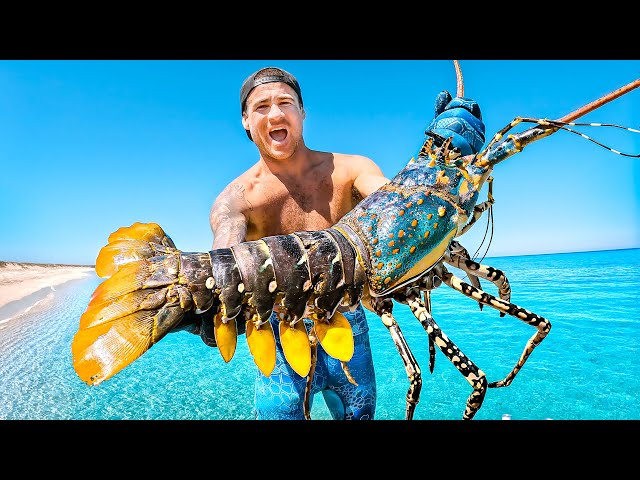

In [ ]:
image = Image.open('lobster.jpg')
image

In [ ]:
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def print_top5(output):
  _, indices = torch.sort(output, descending=True)
  percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
  print([(classes[idx], percentage[idx].item()) for idx in indices[0][:5]])

In [ ]:
output = model(torch.unsqueeze(transform(image), 0).to(device))
print_top5(output)

[('spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 78.88160705566406), ('American lobster, Northern lobster, Maine lobster, Homarus americanus', 15.876886367797852), ('crayfish, crawfish, crawdad, crawdaddy', 4.89248514175415), ('centipede', 0.08870778977870941), ('scorpion', 0.06498516350984573)]


In [ ]:
def numpy_to_img(image_numpy):
  image_numpy = image_numpy.squeeze(0)
  image_numpy = image_numpy.transpose(1, 2, 0)
  image = image_numpy * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  return image

In [ ]:
image_tensor = transform(image).unsqueeze(0)
image_numpy = image_tensor.numpy()

In [ ]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
    input_shape=(3, 224, 224),
    nb_classes=1000,
)

In [ ]:
attack = AutoProjectedGradientDescent(classifier, eps=16/255, eps_step=2/255, max_iter=40, verbose=True)
adv_image = attack.generate(image_numpy)

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Adversarial')

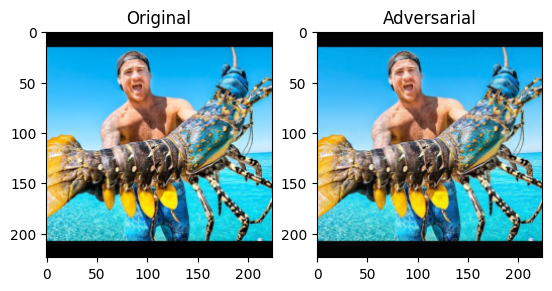

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(numpy_to_img(image_numpy))
ax[0].set_title('Original')
ax[1].imshow(numpy_to_img(adv_image))
ax[1].set_title('Adversarial')

In [ ]:
adv_tensor = torch.from_numpy(adv_image).to(device)
adv_output = model(adv_tensor)
print_top5(adv_output)

[('American lobster, Northern lobster, Maine lobster, Homarus americanus', 98.56480407714844), ('crayfish, crawfish, crawdad, crawdaddy', 0.7931287288665771), ('spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 0.6297736167907715), ('scorpion', 0.0020416604820638895), ('king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica', 0.0013762518065050244)]


In [ ]:
attack = AutoProjectedGradientDescent(classifier, eps=0.2, eps_step=2/255, max_iter=200, verbose=True, targeted=True)
adv_image = attack.generate(x=image_numpy, y=np.array([407]))

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Adversarial')

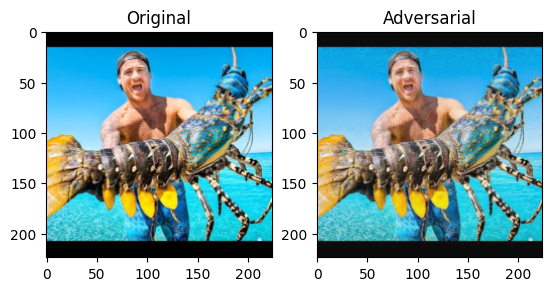

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(numpy_to_img(image_numpy))
ax[0].set_title('Original')
ax[1].imshow(numpy_to_img(adv_image))
ax[1].set_title('Adversarial')

In [ ]:
print_top5(model(torch.from_numpy(adv_image).to(device)))

[('ambulance', 99.99823760986328), ('police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 0.00041666638571769), ('stretcher', 0.00036599041777662933), ('military uniform', 0.00015900348080322146), ('minibus', 0.00011800932406913489)]


In [ ]:
classes[254]

'pug, pug-dog'

In [ ]:
attack = AutoProjectedGradientDescent(classifier, eps=0.15, eps_step=2/255, max_iter=100, verbose=True, targeted=True)
adv_image = attack.generate(x=image_numpy, y=np.array([254]))

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Adversarial')

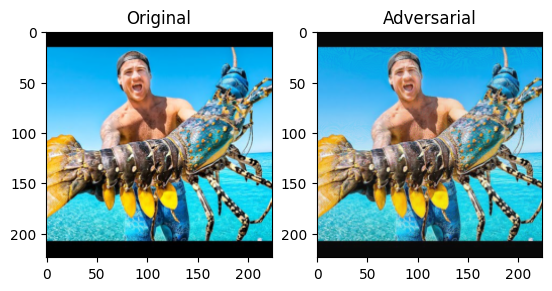

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(numpy_to_img(image_numpy))
ax[0].set_title('Original')
ax[1].imshow(numpy_to_img(adv_image))
ax[1].set_title('Adversarial')

In [ ]:
print_top5(model(torch.from_numpy(adv_image).to(device)))

[('pug, pug-dog', 99.9850845336914), ('French bulldog', 0.002093391725793481), ('bull mastiff', 0.001916650915518403), ('Norwegian elkhound, elkhound', 0.0016608110163360834), ('Chihuahua', 0.0014976657694205642)]
